In [1]:
# package
from collections import OrderedDict
import numpy as np
import torch
from torch import optim
import torch.nn as nn
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# get data dir
from google.colab import drive

drive.mount("/content/drive")

TRAIN_PATH = "/content/drive/MyDrive/DL/Transfer learning/train"
TEST_PATH = "/content/drive/MyDrive/DL/Transfer learning/test"

Mounted at /content/drive


In [15]:
transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])

In [16]:
train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform=transform)

# dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
def imshow(image_torch):
  # flip image channels to RGB
  image_torch = image_torch.numpy().transpose((1, 2, 0))
  plt.figure(figsize=(10, 10))
  plt.imshow(image_torch)

In [18]:
X_train, y_train  = next(iter(train_loader))

# make grid from batch
image_grid = torchvision.utils.make_grid(X_train[:16, :, :, :], scale_each=True, nrow=4)

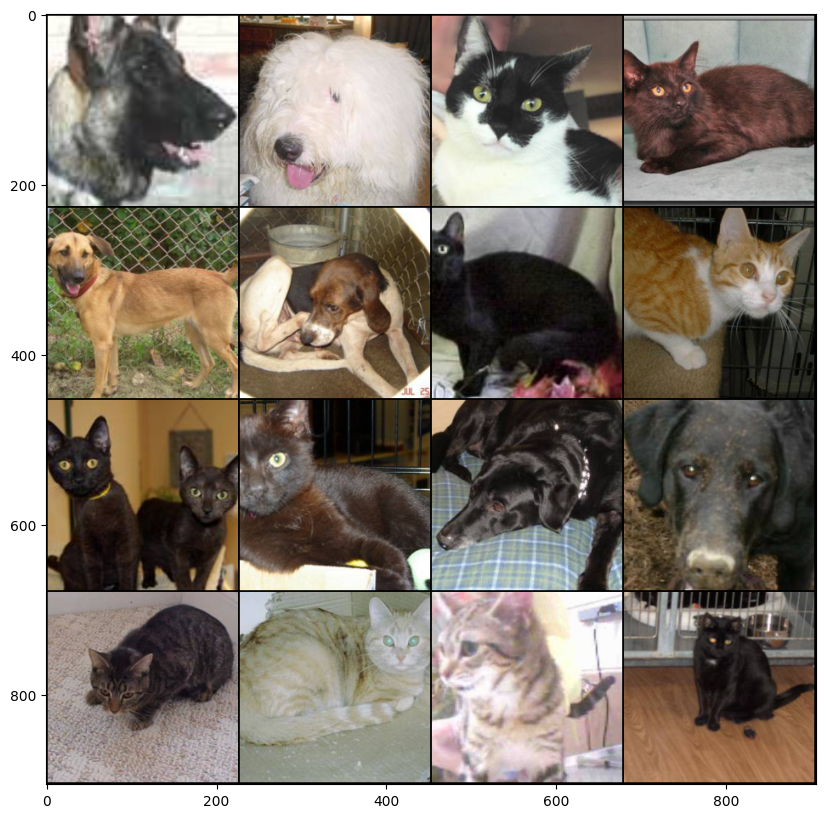

In [19]:
imshow(image_grid)

In [20]:
# Dowload and instantiate the pre-trained network
model = models.densenet121(pretrained = True)

In [21]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
model.classifier # in this dataset, only classify cat, and dog -> 1 out_features

Linear(in_features=1024, out_features=1000, bias=True)

In [23]:
# freeze all layers
for params in model.parameters():
  params.requires_grad = False

In [24]:
# overwrite classifier of the model
model.classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(1024, 1)),
    ('sigmoid', nn.Sigmoid()),
]))

In [25]:
# model training
optimizer = optim.Adam(model.classifier.parameters())
loss_function = nn.BCELoss()
train_losses = []


# Setup thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

NUM_EPOCHS = 10
for epoch in range(NUM_EPOCHS):
  train_loss = 0
  test_loss = 0

  for batch, (image, label) in enumerate(train_loader):

    image = image.to(device)
    label = label.to(device)

    # zero gradients
    optimizer.zero_grad()

    # forward pass
    output = model(image)

    # calc losses
    loss = loss_function(output.squeeze(), label.float())

    # back propa
    loss.backward()

    # update weights
    optimizer.step()

    # update current train loss
    train_loss += loss.item()

  train_losses.append(train_loss)
  print(f"Epoch: {epoch}, Train Loss: {train_loss}")

Epoch: 0, Train Loss: 4.508977949619293
Epoch: 1, Train Loss: 3.4707770943641663
Epoch: 2, Train Loss: 2.827752411365509
Epoch: 3, Train Loss: 2.398472011089325
Epoch: 4, Train Loss: 1.919836238026619
Epoch: 5, Train Loss: 1.9175450950860977
Epoch: 6, Train Loss: 1.510003224015236
Epoch: 7, Train Loss: 1.3661218136548996
Epoch: 8, Train Loss: 1.5583088397979736
Epoch: 9, Train Loss: 1.1481345891952515


<Axes: >

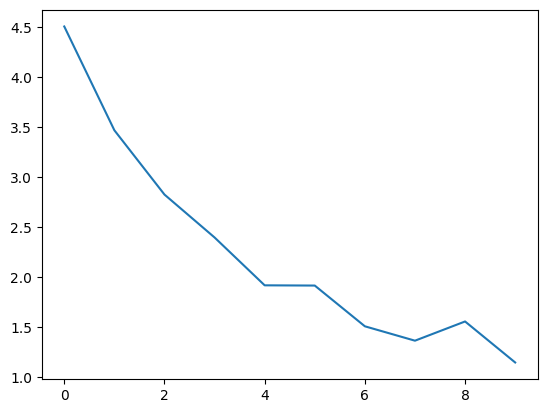

In [26]:
# losses over epoch
sns.lineplot(x = range(NUM_EPOCHS), y = train_losses)

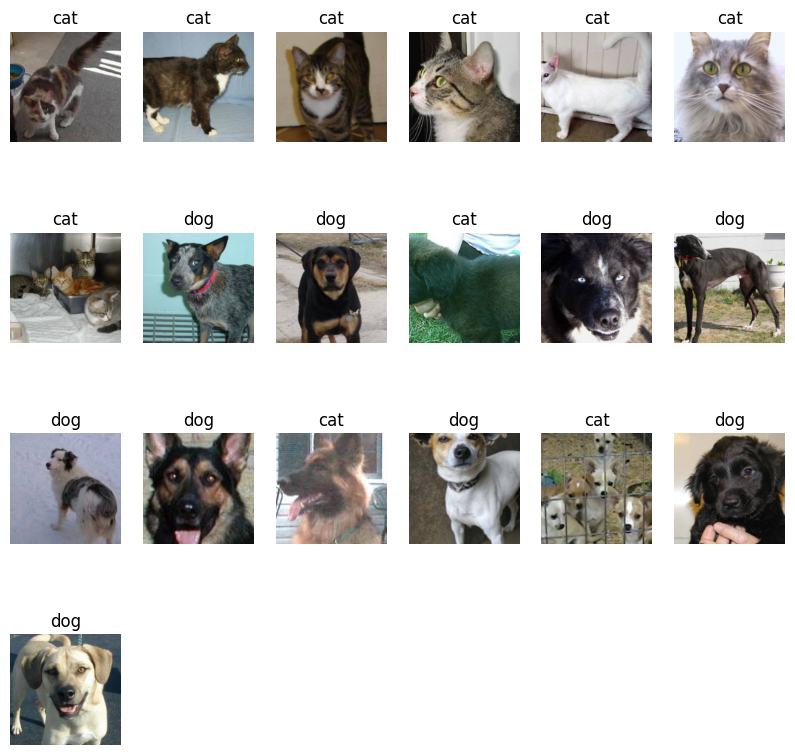

In [30]:
fig = plt.figure(figsize=(10, 10))
class_labels = {0: 'cat', 1: 'dog'}
X_test, y_test = next(iter(test_loader))

with torch.no_grad():
  X_test = X_test.to(device)
  y_pred = model(X_test)
  y_pred = y_pred.round()
  y_pred = [p.item() for p in y_pred]


# create subplots
for num, sample in enumerate(X_test):
  plt.subplot(4, 6, num+1)
  plt.title(class_labels[y_pred[num]])
  plt.axis('off')
  sample = sample.cpu().numpy()
  plt.imshow(np.transpose(sample, (1, 2, 0)))

In [31]:
# calc accuracy
acc  = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc}")

Accuracy: 0.8421052631578947
